In [1]:
import pandas as pd
import numpy as np

from pymongo import MongoClient
import os
import dotenv

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as py

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Mongo connection, extract and normalize

In [2]:
dotenv.load_dotenv()
MGURL = os.getenv("MGURL")
myclient = MongoClient(f"{MGURL}")
db = myclient.github

In [3]:
git = list(db.profiles.find({},{"_id":0, "company":0, "location":0, "email":0, "hireable":0}))

In [4]:
df = pd.json_normalize(git, "repos", ["name","repos_number","followers","created","updated"])

### Clean and prepare dataframe

In [5]:
print(df.shape)
df.head()

(1037132, 10)


repo_name  forked  stars  \
0                                      AwesomeNER   False      6   
1                     coding-interview-university    True      2   
2                            COMP2396-assignments   False      0   
3             Computer-and-Communication-Networks   False      0   
4  Costa-Rican-Household-Poverty-Level-Prediction   False      0   

           language  forks           name repos_number followers  \
0  Jupyter Notebook      2  Tarun Sudhams           23        33   
1              None      1  Tarun Sudhams           23        33   
2              Java      0  Tarun Sudhams           23        33   
3            Python      1  Tarun Sudhams           23        33   
4              HTML      4  Tarun Sudhams           23        33   

                created               updated  
0  2016-05-27T06:16:14Z  2020-05-05T07:34:00Z  
1  2016-05-27T06:16:14Z  2020-05-05T07:34:00Z  
2  2016-05-27T06:16:14Z  2020-05-05T07:34:00Z  
3  2016-05-27T06:16:14Z  2020-05-05T07:34:00Z  
4  2016-05-27T06:16:14Z  2020-05-05T07:34:00Z

In [6]:
df.created = df.created.str.replace(r"\b(?:(?!\d{4}-\d{2}).*)","")
df.updated = df.updated.str.replace(r"\b(?:(?!\d{4}-\d{2}).*)","")
df.drop(columns={"repo_name", "language"}, inplace=True)

In [7]:
df.isnull().sum()

forked              0
stars               0
forks               0
name            33898
repos_number        0
followers           0
created             0
updated             0
dtype: int64

In [8]:
df["years"] = df.updated.astype(int)-df.created.astype(int)
df.drop(columns={"created","updated"}, axis=1, inplace=True)
df.dropna(how="any", inplace=True)

In [9]:
print(df.shape)
df.isnull().sum()

(1003234, 7)


forked          0
stars           0
forks           0
name            0
repos_number    0
followers       0
years           0
dtype: int64

In [10]:
num = df.groupby(["name", "repos_number", "followers", "years"]).agg({"stars":"sum", "forks":"sum"}).reset_index()

In [11]:
num[num.name=="Tarun Sudhams"]

name  repos_number  followers  years  stars  forks
33492  Tarun Sudhams            23         33      4     49     38

In [12]:
cat = df.groupby(["name","forked"]).size().unstack(fill_value=0).reset_index().rename(columns={"index":"name",False:"user_repo",True:"forked_repo"})

In [13]:
cat[cat.name=="Tarun Sudhams"]

forked           name  user_repo  forked_repo
32038   Tarun Sudhams         19            4

In [14]:
df = pd.merge(num, cat, on="name")

In [15]:
df[df.name=="Tarun Sudhams"]

name  repos_number  followers  years  stars  forks  user_repo  \
33492  Tarun Sudhams            23         33      4     49     38         19   

       forked_repo  
33492            4

### Descriptive Analysis

In [16]:
print(df.shape)
df.head()

(41335, 8)


name  repos_number  followers  years  stars  forks  \
0   Aníbal Catheringer             2          1      6      0      0   
1                Cohen            18          2      3      0      2   
2     Enrico Antonello            43         14      7      7      2   
3         Jakub Smadiš            16          1      3      0      0   
4         Marián Černý            16          3      8     22      6   

   user_repo  forked_repo  
0          2            0  
1         18            0  
2         28           15  
3          3           13  
4          3           13

In [17]:
df.describe()

repos_number     followers         years          stars         forks  \
count  41335.000000  41335.000000  41335.000000   41335.000000  41335.000000   
mean      24.288521     23.928680      6.178275      76.527979     20.784081   
std      105.041222    339.126622      2.887503     998.011995    290.819093   
min        1.000000      0.000000      0.000000       0.000000      0.000000   
25%        5.000000      3.000000      4.000000       0.000000      0.000000   
50%       12.000000      6.000000      6.000000       3.000000      1.000000   
75%       27.000000     13.000000      8.000000      14.000000      6.000000   
max    14637.000000  57545.000000     12.000000  123102.000000  34154.000000   

          user_repo   forked_repo  
count  41335.000000  41335.000000  
mean      15.033410     16.244345  
std       53.370244    103.753181  
min        0.000000      0.000000  
25%        3.000000      1.000000  
50%        7.000000      4.000000  
75%       16.000000     12.000000  
max     9349.000000  14433.000000

In [18]:
X = df.drop(columns={"name"})

In [19]:
#we can observe a lot of rows with at least 1 column > 1k. Mainly stars and forks, while any mean is higher than 400
outliers = df[(X>1000).any(1)]
print(outliers.shape)
outliers.head()

(549, 8)


name  repos_number  followers  years  stars  forks  \
361    Adam Coddington           185        174     10   1975    434   
421        Adam Mckaig           141        358     12   2029    461   
467      Adam Zapletal            31         72     11   1987    376   
1080      Alberto Paro           122        129     12   1108    401   
1083  Alberto Pettarin            49         72      7   1071    271   

      user_repo  forked_repo  
361         120           65  
421          82           59  
467          10           21  
1080         30           92  
1083         29           20

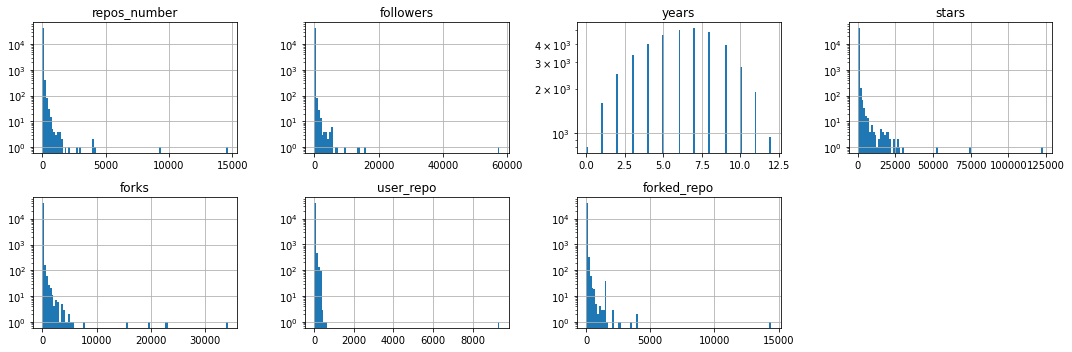

In [20]:
#we can see in all variables except for years and stars that the frequency of 0 es huge
figure = plt.figure(figsize=(15,5))

for n, c in enumerate(X.columns):
  ax = figure.add_subplot(2,4,n+1)
  ax.set_title(c)
  ax.set_yscale("log") #the log scale help us to have a better idea of our data when the distribution is not fair
  X[c].hist(ax=ax, bins=100)

figure.tight_layout() #this feature separate the graphs correctly
plt.show()

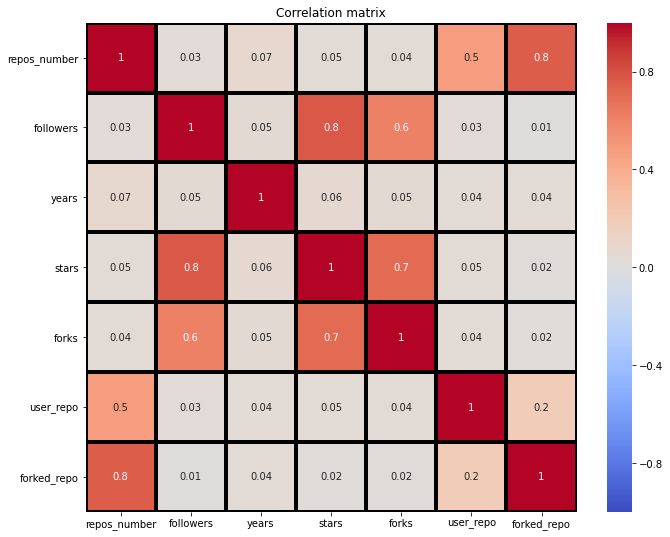

In [21]:
plt.figure(figsize=(11,9))

sns.heatmap(X.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm' , linewidths=3, linecolor='black')

plt.title('Correlation matrix')
plt.show()

#### There is a big positive linear relation between followers, stars and forks. However none of the repo columns  neither yeas are related with the 3 previous vars. Therefore we will take these 3 vars as the main characteristics to determine the seniority of users

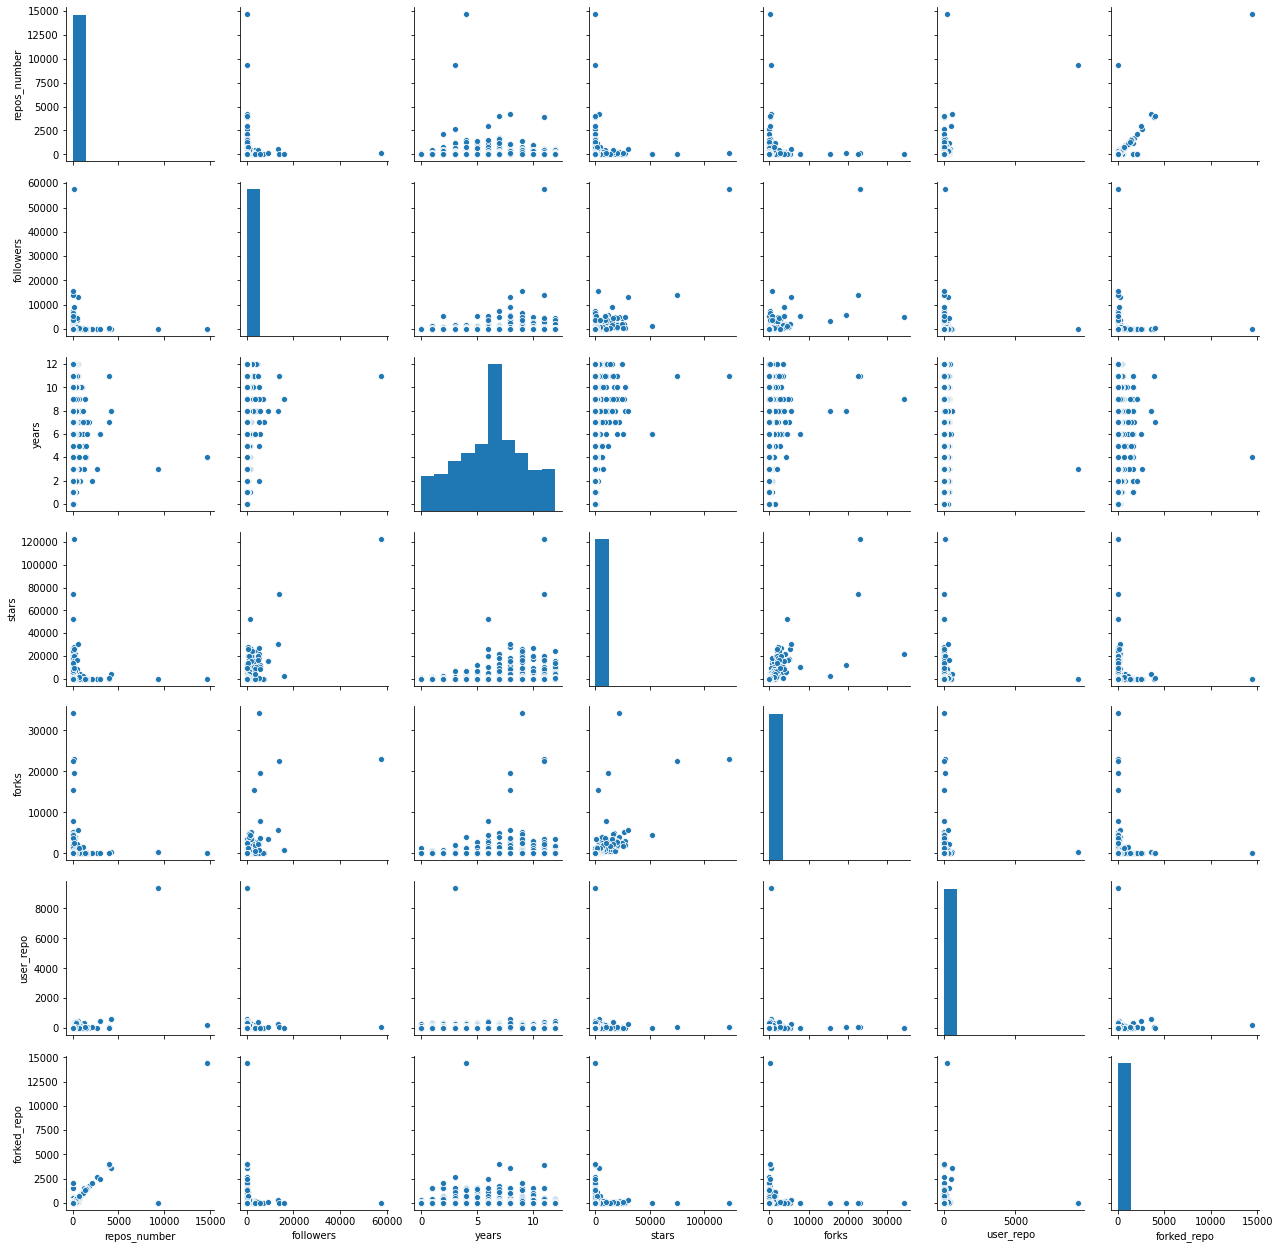

In [22]:
sns.pairplot(X)
plt.show()

#### Above we can see some columns with really huge outliers that could affect our cluster model. Therefore we will eliminate them

In [33]:
df[(X>10000).any(1)]

name  repos_number  followers  years   stars  forks  \
1822   Alexander Lukyanchikov            22        762      7   17038   4981   
2195             Allen Downey           105       5713      8   12031  19572   
2518           Andrea Cardaci            32        420      8   11256   1029   
2649           Andrea Mazzini           126       1183      9   19122   2196   
3087              Andrew Carl         14637         27      4      48     39   
3242            Andrey Sitnik            60       4506     12   24147   1974   
3878           Artur Arseniev            45        664      5   12172   2796   
4938              Brad Larson            23       1928      9   26037   5292   
5048            Brendan Gregg            42       4461      8   18460   2712   
5137              Brian Caffo            57       3250      8    2481  15378   
6155              Chris Fritz           148       3241      8   15036   2440   
8031         Daniele Margutti            71       1111     10   18537   1800   
10270              Endre Simo            44        670      9   14844    677   
10624                   Eugen             9       5119      9   21710  34154   
10963            Fatih Arslan            46       5132     10   26919   3054   
11125         Federico Zivolo           232       1671      7   22046   3908   
11305    Filippo Scognamiglio            11        238      7   12774    608   
11413              Florin Pop            69       2216      6   20048   2765   
12113       Gabriele Mariotti            25       2563      8   10807   2994   
12881            Giulio Canti           101       1444      9   18866   1412   
15084            Jake Wharton           102      57545     11  123102  23075   
16856         John Holdsworth            57       1011      8   14225   1127   
17114           Jonathan Neal           364        964     10   16829   1739   
17347             Josh Buchea           160        534      8   27562   2129   
18622      Kenneth Auchenberg           200        925     11   18413    687   
18654           Kent C. Dodds           561      13401      8   30336   5622   
18791           Kevin Markham            38       5497      6   10025   7797   
19223              Kris Kowal           156       1804     11   19640   1688   
19364          Kyle Kingsbury           101       3801     12   10638    848   
21889            Mark Erikson            60       2083      9   24469   2482   
22935           Matteo Crippa           182        570     10   20279   2909   
23071         Matteo Spinelli            36        886      9   16230   4818   
24268             Mihai Bazon            41        893     10   19898   2040   
26359         Olivier Poitrey           109       2943     11   15629   1831   
27475            Peter Norvig             4       5181      7   18317   2195   
27752          Phil Hagelberg           141       1853     12   15133   3581   
29894         Ryan L McIntyre           150        447      6   25723   1854   
30327    Salvatore Sanfilippo            63      13833     11   74629  22542   
31874     Simone Margaritelli           124       4706     11   20148   2854   
32133        Soumith Chintala           156       9220      8   15372   3616   
33975             Tim Caswell           457       4693     11   16466   2375   
35253             Valentin V.            57        470     12   13861   1918   
36831           Yoni Goldberg            18       1240      6   52132   4595   
37640              Zihan Chen             7      15832      9    2573    748   

       user_repo  forked_repo  
1822           6           16  
2195          78           27  
2518          27            5  
2649          31           95  
3087         204        14433  
3242          58            2  
3878          33           12  
4938          17            6  
5048          28           14  
5137          37           20  
6155          82           66  
8031          57           14  
10270   

In [35]:
df.drop(df[(X>10000).any(1)].index, inplace=True)

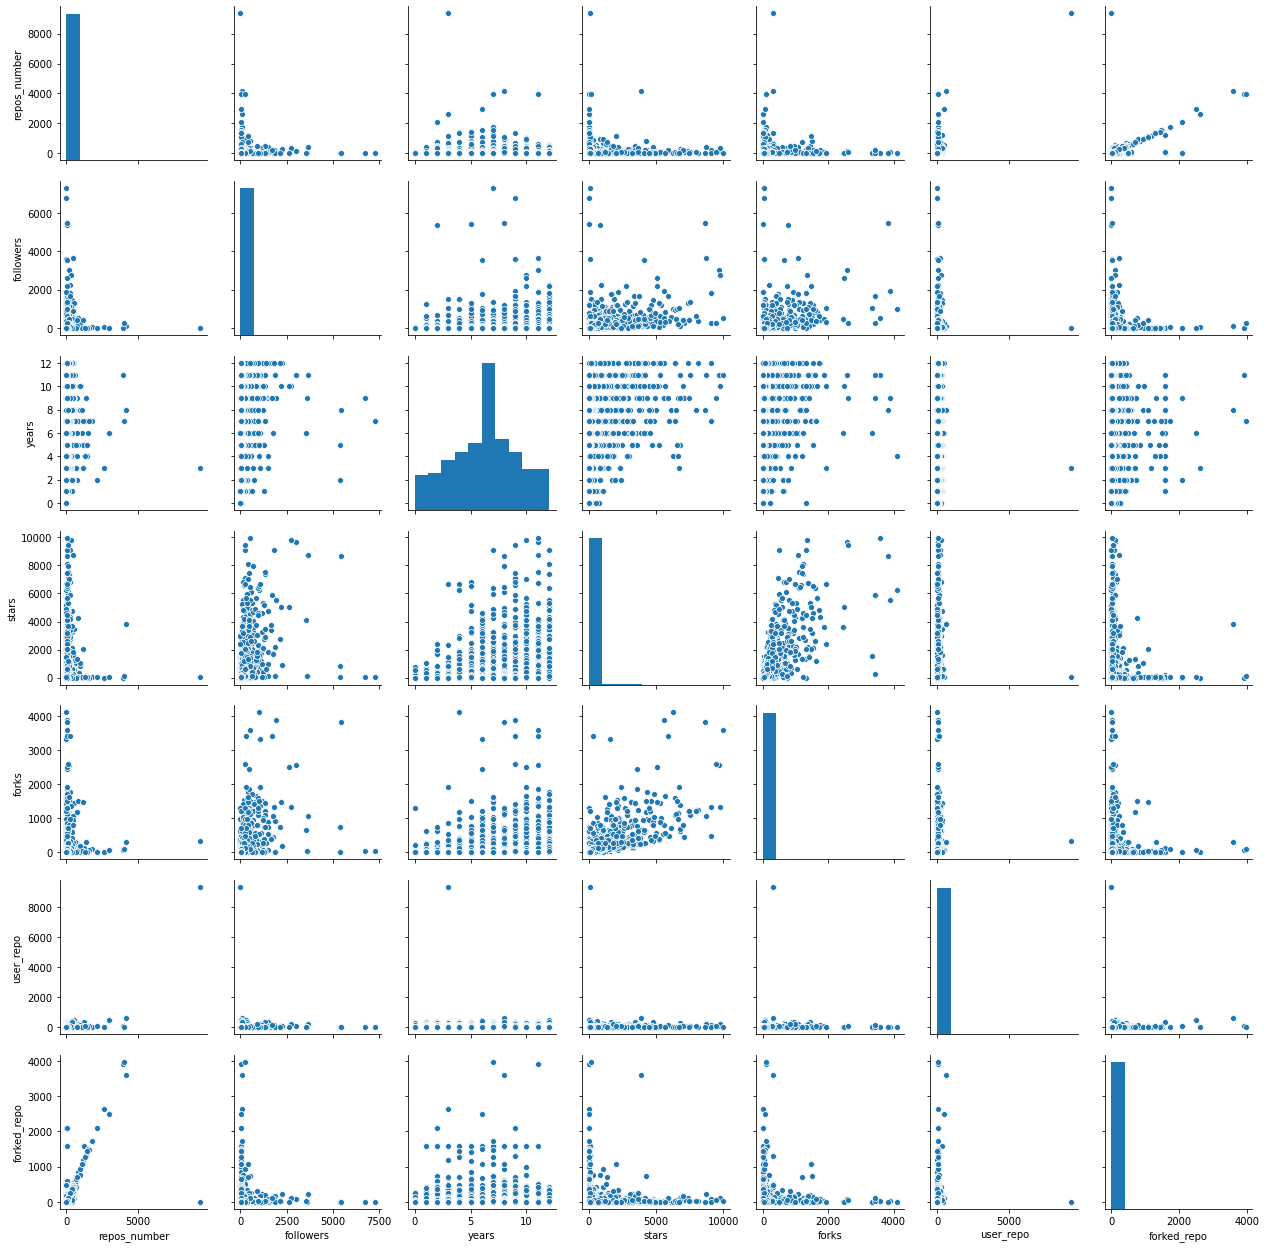

In [36]:
sns.pairplot(df)
plt.show()

#### Now almost all columns look good, but repos_number and followers still have some outliers over 5k, lets eliminate them too

In [39]:
df.drop(df[(X.repos_number>5000)|(X.followers>5000)].index, inplace=True)

/home/diego/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



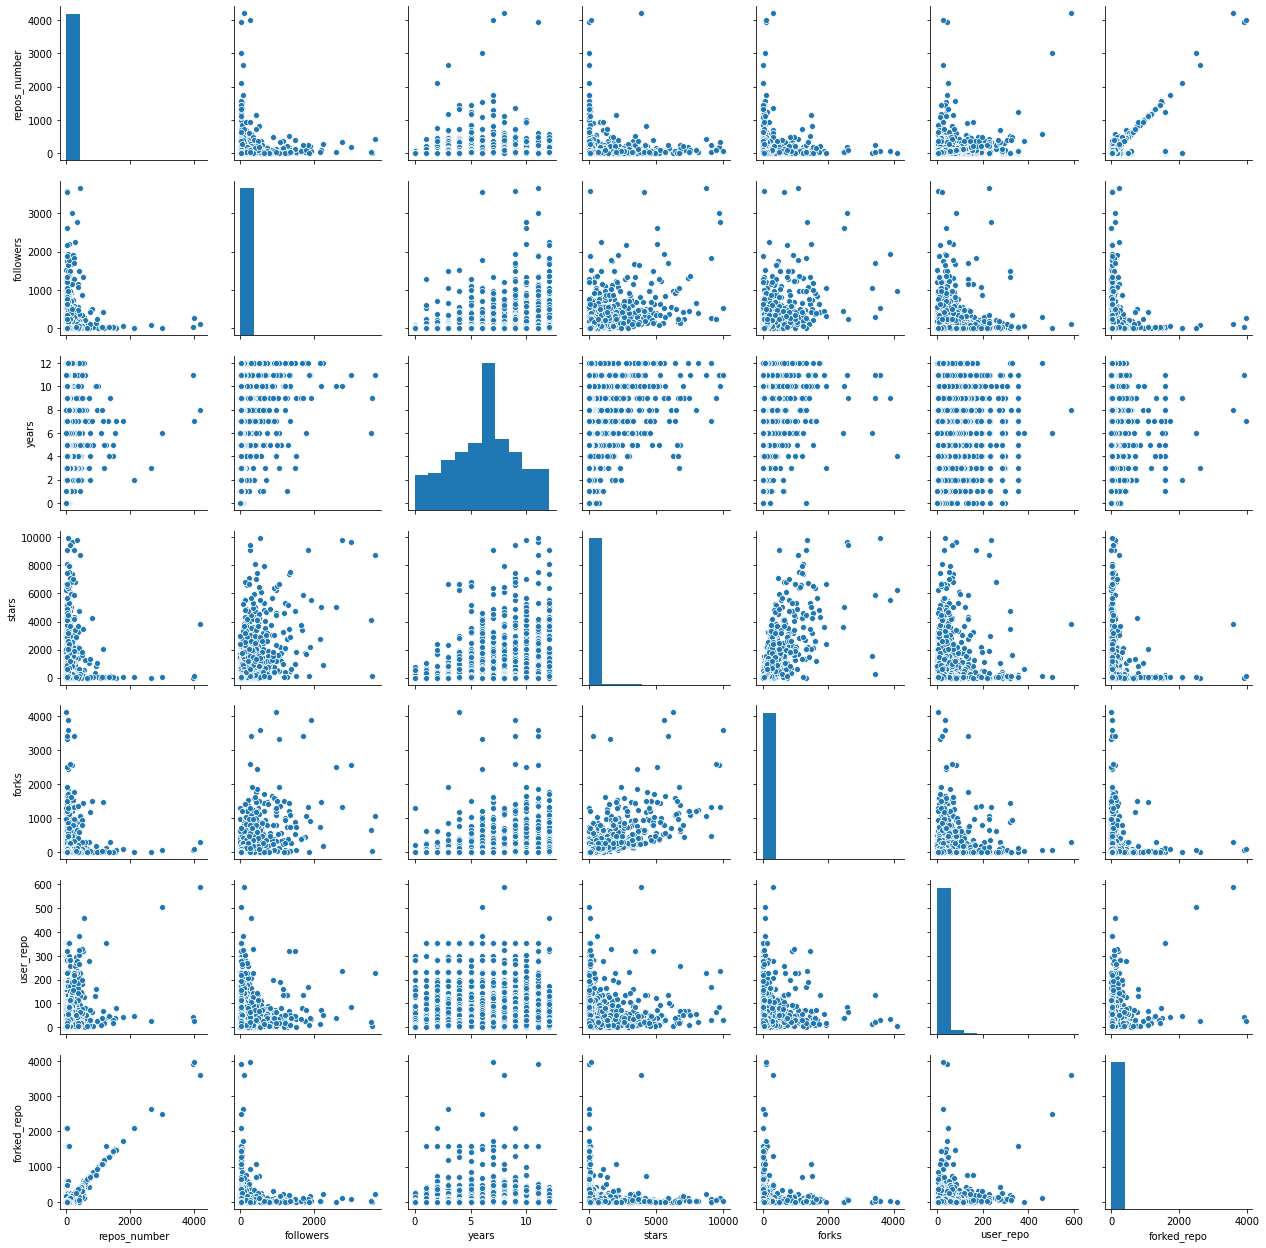

In [40]:
sns.pairplot(df)
plt.show()

In [41]:
df.describe()

repos_number     followers         years         stars         forks  \
count  41285.000000  41285.000000  41285.000000  41285.000000  41285.000000   
mean      23.623374     18.460579      6.175536     53.471212     15.484922   
std       61.216393     77.080811      2.887077    320.008054     86.230918   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%        5.000000      3.000000      4.000000      0.000000      0.000000   
50%       12.000000      6.000000      6.000000      3.000000      1.000000   
75%       27.000000     13.000000      8.000000     14.000000      6.000000   
max     4196.000000   3656.000000     12.000000   9979.000000   4111.000000   

          user_repo   forked_repo  
count  41285.000000  41285.000000  
mean      14.754172     15.866901  
std       27.069696     75.753775  
min        0.000000      0.000000  
25%        3.000000      1.000000  
50%        7.000000      4.000000  
75%       16.000000     12.000000  
max      588.000000   3966.000000

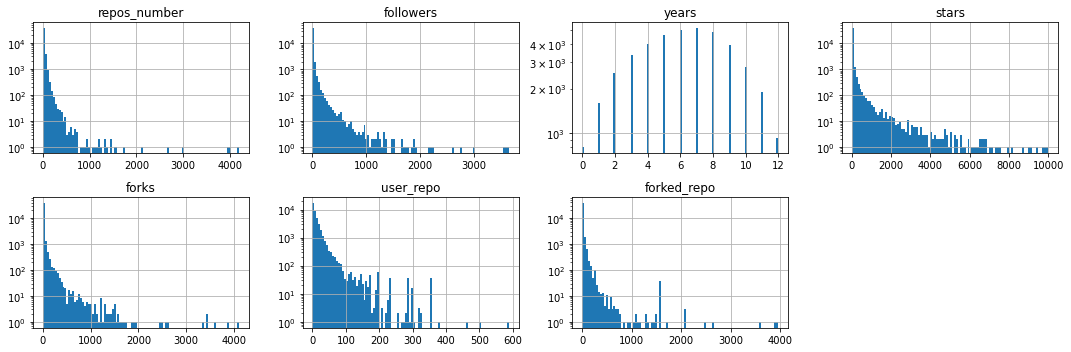

In [50]:
fig = plt.figure(figsize=(15,5))

for n, c in enumerate(df.drop(columns={"name"}).columns):
    ax = fig.add_subplot(2,4,n+1)
    ax.set_title(c)
    ax.set_yscale("log")
    df[c].hist(ax=ax, bins=100)

fig.tight_layout() #this feature separate the graphs correctly
plt.show()

#### Now the distribution of our sample looks fairer so we will proceed with the PCA and the clustering with K Means

In [51]:
#we will exclude the id and the repos_number as we will use the user_repo and forked_repo for clustering
name = df.name
repos = df.repos_number
X = df.drop(columns={"name","repos_number"})

### Scale

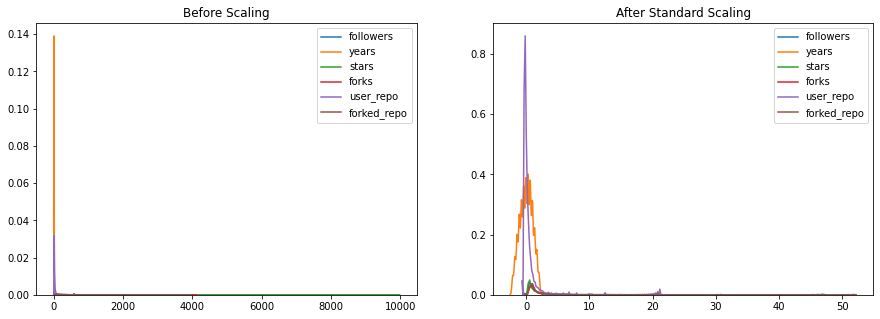

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

strans = scaler.fit_transform(X)

X_SS = pd.DataFrame(strans)
X_SS.columns = X.columns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.set_title('Before Scaling')
for e in X.columns:
    sns.kdeplot(X[e], ax=ax1, legend=True)
ax2.set_title('After Standard Scaling')
for e in X_SS.columns:
    sns.kdeplot(X_SS[e], ax=ax2, legend=True)
plt.show()

#### We show it again

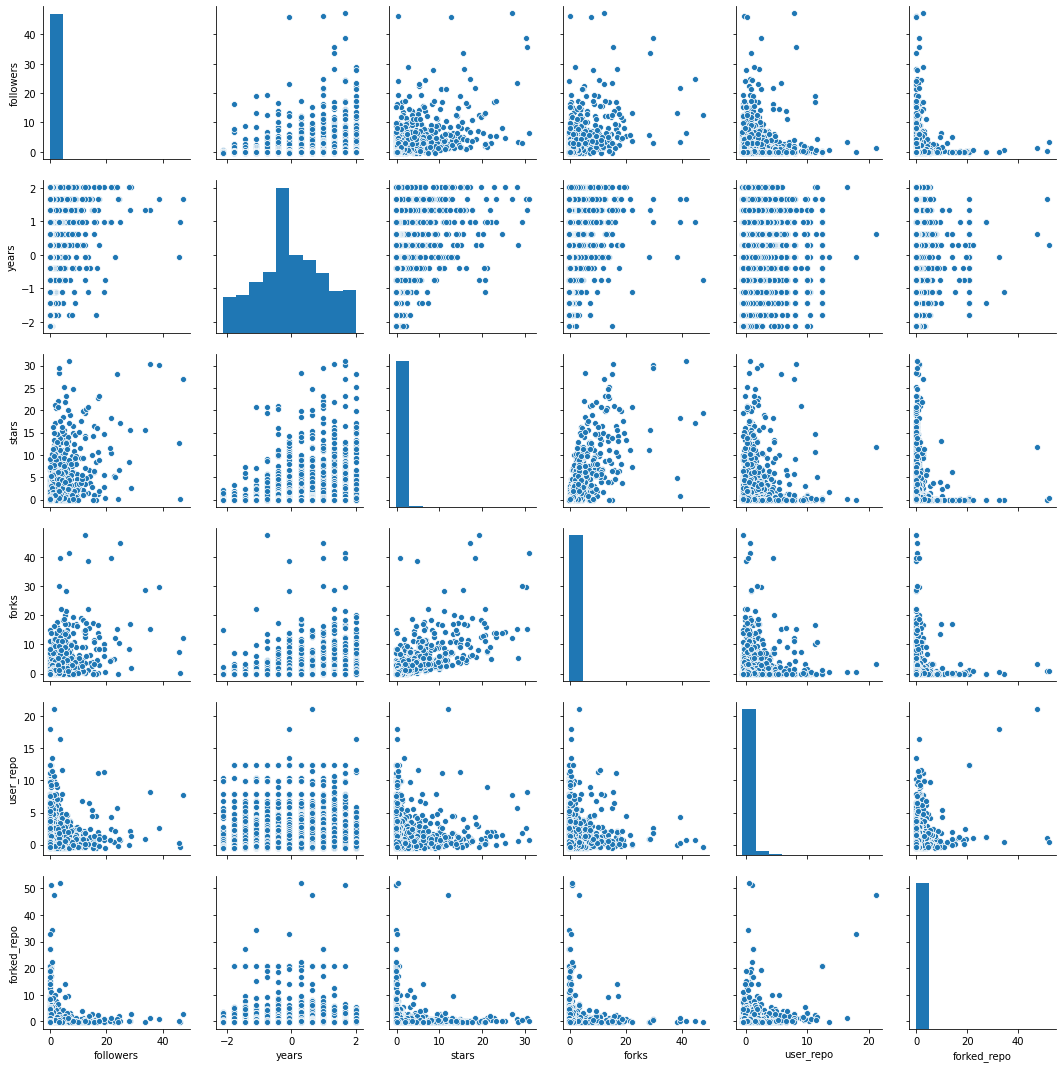

In [54]:
sns.pairplot(X_SS)
plt.show()

#### Now we can see the are just a few outliers

#### Before impletementing the PCA dimensionality reduction lets check the dimensions

/home/diego/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning:

Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.



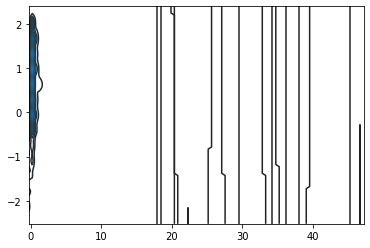

In [55]:
sns.kdeplot(X_SS)

#### Seems to be more than 3 

In [56]:
X_SS.shape

(41285, 6)

#### 6 dimensions actually

### PCA -- Choosing number of components

In [57]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_SS)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [58]:
pca.explained_variance_ratio_

array([0.40649144, 0.23686805, 0.15927256, 0.08437359, 0.07539351,
       0.03760084])

Text(0, 0.5, 'Cummulative Explained Variance')

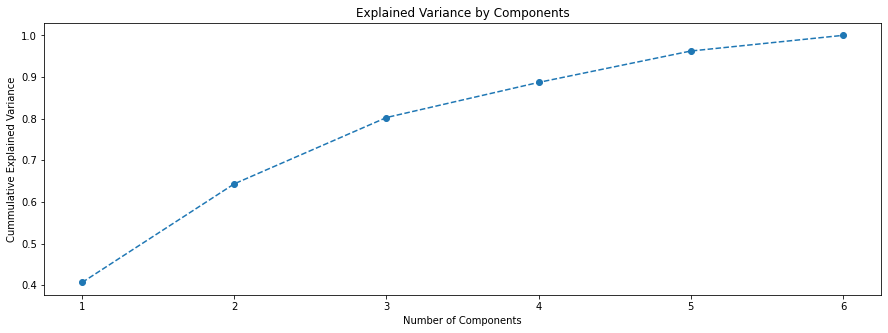

In [64]:
plt.figure(figsize=(15,5)) 
plt.plot(range(1,7), pca.explained_variance_ratio_.cumsum(), marker="o", linestyle="--")
plt.title("Explained Variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cummulative Explained Variance")

#### The graph shows the amount of variance captured (on the y-axis) depending on the number of components we include (the x-axis). A rule of thumb is to preserve around 80 % of the variance. So, in this instance, we decide to keep 3 components.

In [65]:
pca = PCA(n_components=3).fit(X_SS)
X_3d = pca.transform(X_SS)

In [66]:
X_3d.shape

(41285, 3)

In [67]:
pca.components_

array([[ 0.51607085,  0.1709844 ,  0.56282472,  0.55813528,  0.22786803,
         0.15564289],
       [-0.1379162 ,  0.08004528, -0.17856582, -0.17774851,  0.65351278,
         0.69571017],
       [ 0.02719283, -0.97997959,  0.10419133,  0.10995617,  0.08073312,
         0.09714175]])

In [68]:
pca.explained_variance_ratio_

array([0.40649144, 0.23686805, 0.15927256])

### Silhouette Score

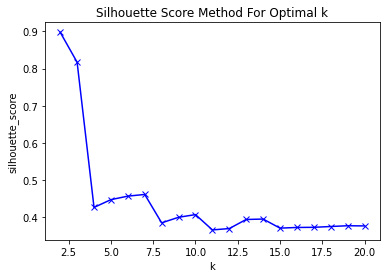

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [69]:
#we use the silhouette method to determine the ideal number of clusters. Although our clusters objective is 4-7
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil = []
kmax = 20
klusters = range(2, kmax+1)
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in klusters:
    km = KMeans(n_clusters = k).fit(X_3d)
    labels = km.labels_
    sil.append(silhouette_score(X_3d, labels, metric = 'euclidean'))
    
plt.plot(klusters, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Score Method For Optimal k')
plt.show()
%time

- Standard Scaler --> Optimal Clusters 2

#### The optimal number of clusters is 2, but we want between 5-7 so we will start with 7, see how it goes and maybe we will exclude outliers

In [70]:
model = KMeans(n_clusters=7)

labels = model.fit_predict(X_3d)

In [105]:
df_pca_kmeans = pd.concat([X, pd.DataFrame(X_3d).rename(columns={0:"Component1", 1:"Component2", 2:"Component3"}), pd.DataFrame(labels).rename(columns={0:"label"})], axis=1)
df_pca_kmeans.dropna(how="any", inplace=True)
df_pca_kmeans.head()

followers  years  stars  forks  user_repo  forked_repo  Component1  \
0        1.0    6.0    0.0    0.0        2.0          0.0   -0.461537   
1        2.0    3.0    0.0    2.0       18.0          0.0   -0.484884   
2       14.0    7.0    7.0    2.0       28.0         15.0   -0.040332   
3        1.0    3.0    0.0    0.0        3.0         13.0   -0.604084   
4        3.0    8.0   22.0    6.0        3.0         13.0   -0.217040   

   Component2  Component3  label  
0   -0.365502   -0.042117    1.0  
1   -0.068317    1.026828    3.0  
2    0.396390   -0.275363    1.0  
3   -0.305146    0.995858    3.0  
4   -0.194740   -0.685826    1.0

### 3D Graphs
I ll do it in matplotlib and interactive in plotly to have both versions

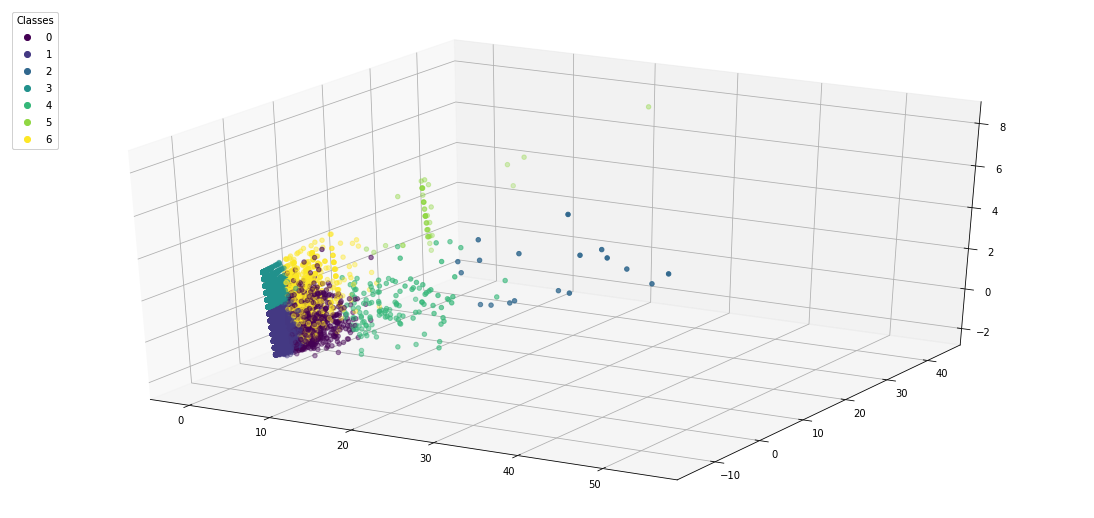

In [106]:
x = df_pca_kmeans.Component1
y = df_pca_kmeans.Component2
z = df_pca_kmeans.Component3

fig = plt.figure()
ax = Axes3D(fig)

scatter = ax.scatter(x, y, z, c=df_pca_kmeans.label)

legend = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes")

ax.add_artist(legend)
plt.show()

In [110]:
clust = df_pca_kmeans.iloc[:,6:]

In [111]:
cont = []
for i in range(6):
    fig = go.Scatter3d(x=clust.Component1[clust.label==i],
                        y=clust.Component2[clust.label==i],
                        z=clust.Component3[clust.label==i],
                        marker=dict(opacity=0.9,
                                    reversescale=True,
                                    colorscale='Blues',
                                    size=5),
                        line=dict (width=0.02),
                        mode='markers')

    cont.append(fig)    
    
#Make Plot.ly Layout
mylayout = go.Layout(scene=dict(xaxis=dict( title="PCA1"),
                                yaxis=dict( title="PCA2"),
                                zaxis=dict(title="PCA3")),)

#Plot and save html

py.iplot({"data": cont,
                     "layout": mylayout},
                     filename=("3DPlot.html"))

<img src='../OUTPUT/3d.png'/>

In [112]:
lab = df_pca_kmeans.label.value_counts()
lab

1.0    23017
3.0    16373
6.0      871
0.0      775
4.0      132
5.0       49
2.0       18
Name: label, dtype: int64

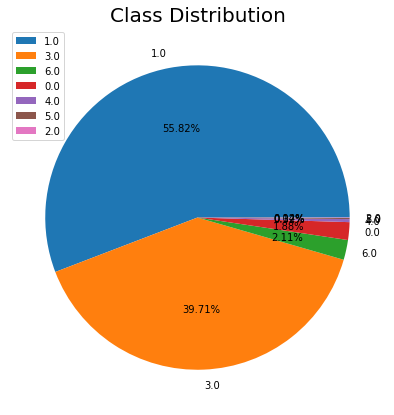

In [113]:
plt.rcParams['figure.figsize'] = (15, 7)
plt.pie(lab, labels = lab.keys(), autopct = '%.2f%%')
plt.title('Class Distribution', fontsize = 20)
plt.axis('off')
plt.legend(loc=2)
plt.show()

#### We can clearly see the 7 classes in the 3D graphs, however the distribution of the classes is really unfair to obtain clearly programmers by seniority. However we are going to see how each class is identified in each variable

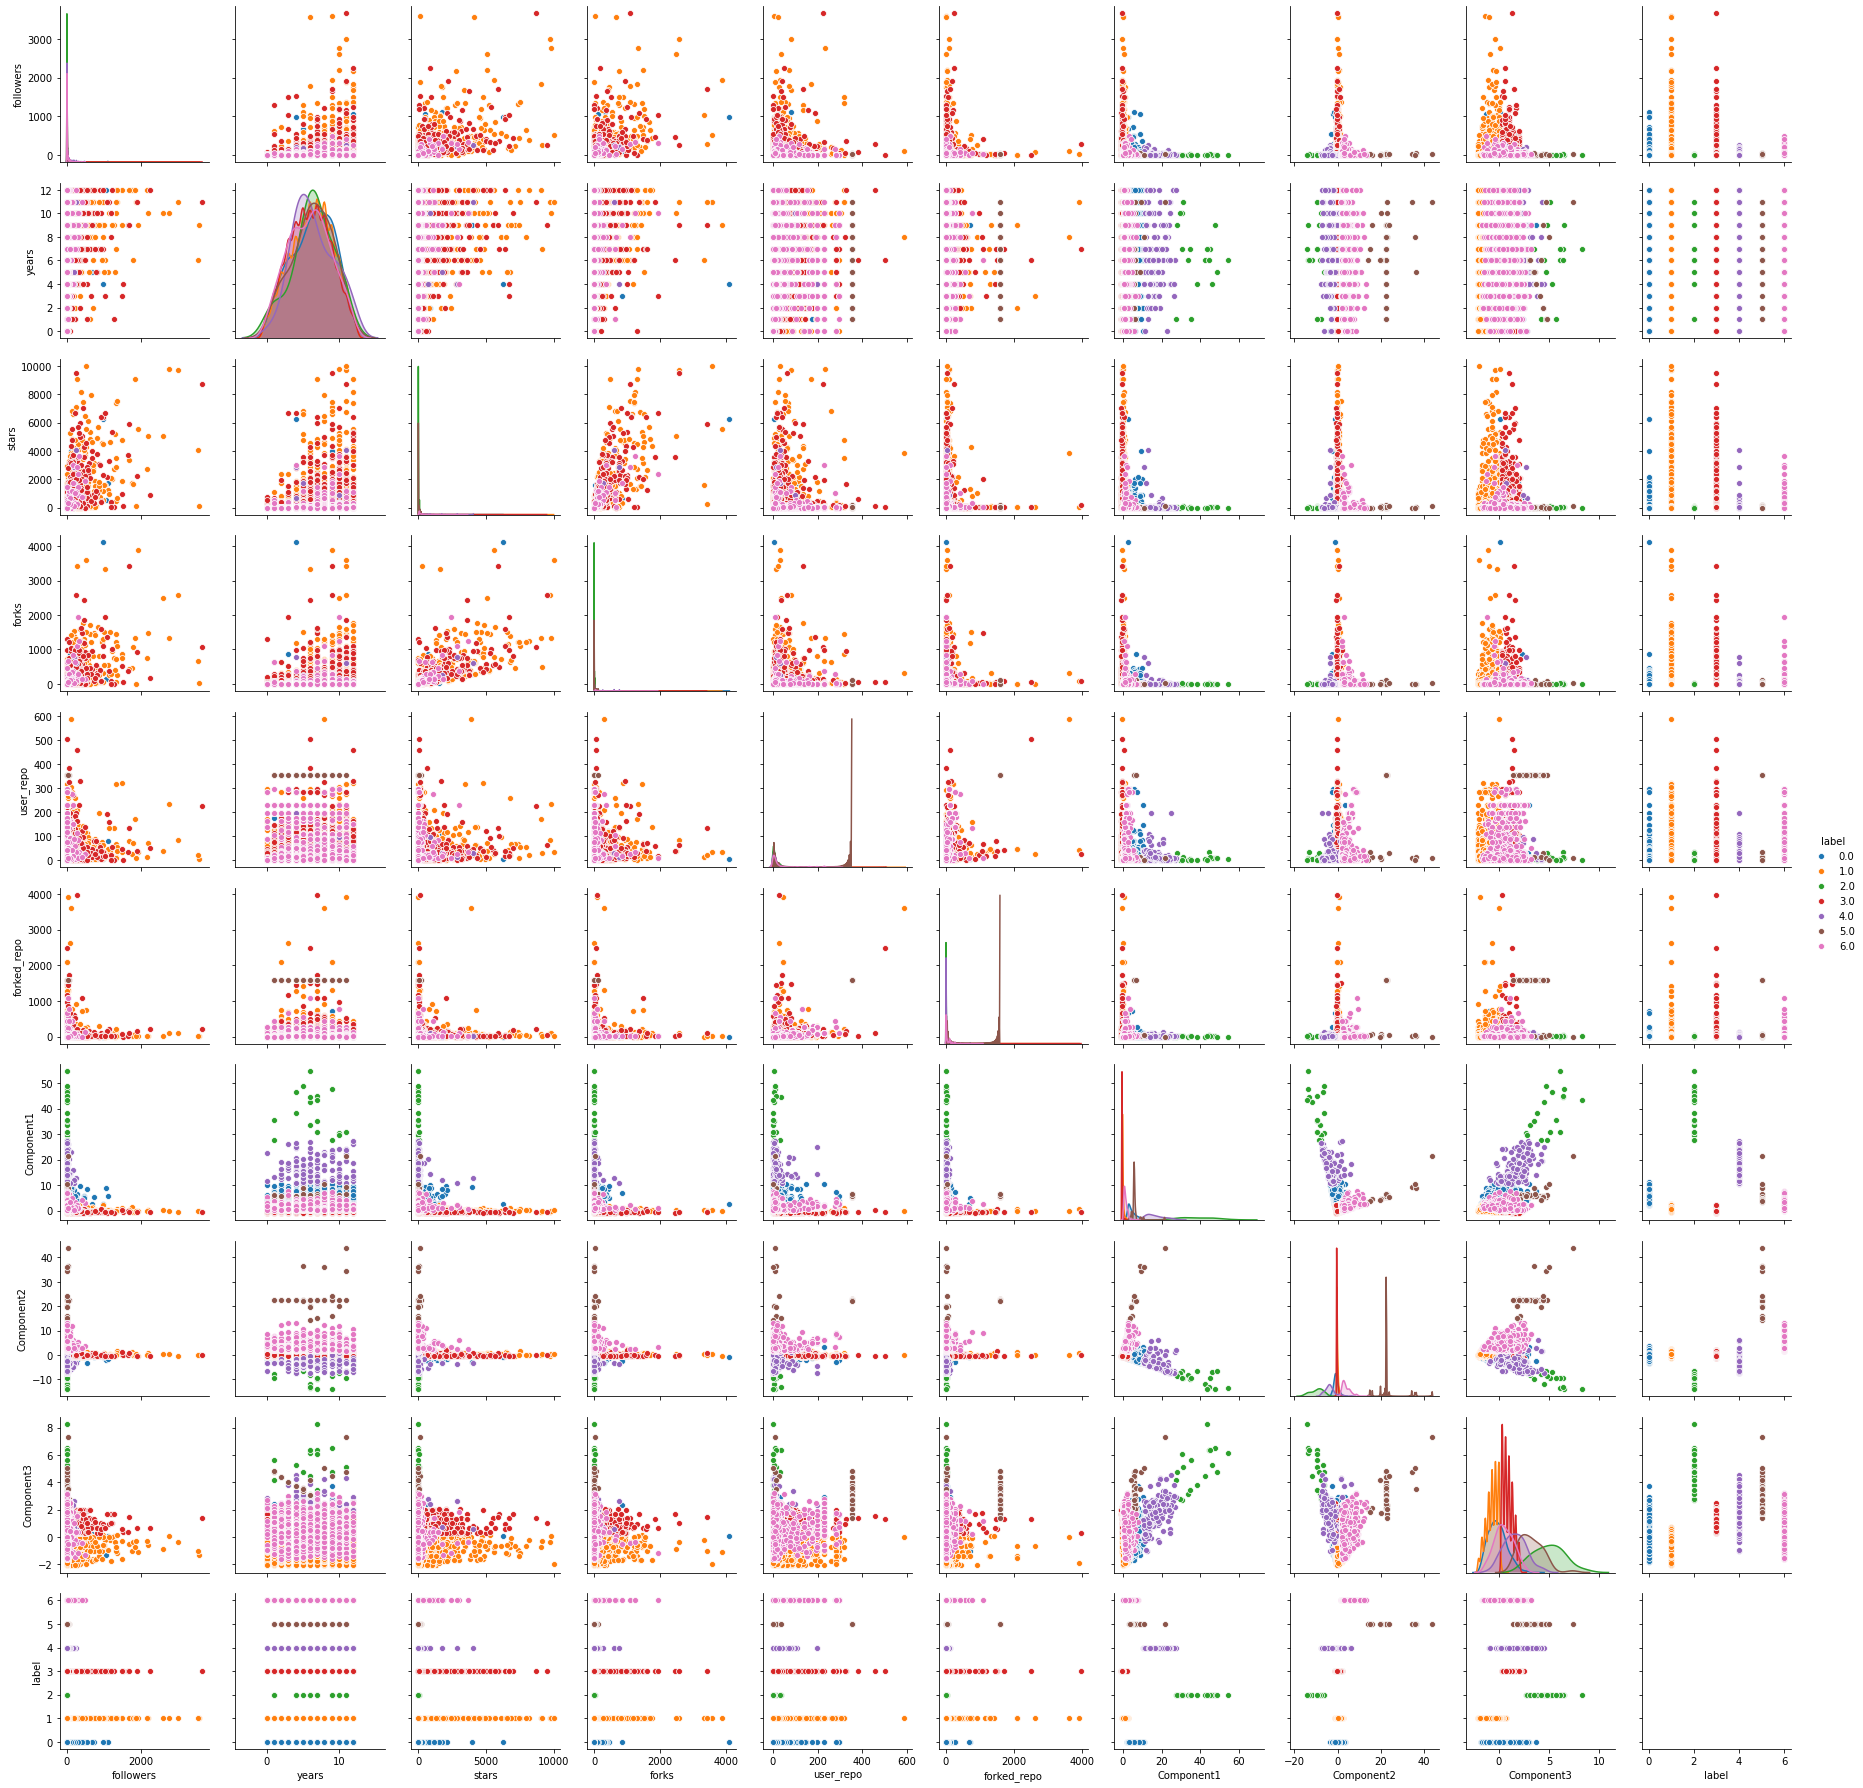

In [115]:
import warnings
warnings.filterwarnings("ignore")

sns.pairplot(df_pca_kmeans, hue="label")
plt.show()

### Conlusions from the graph:
#### All the variables are really mixed and there are not clear different labels in any of them, so the clustering is clearly a mix of all the variables

In [116]:
df_pca_kmeans.describe()

followers         years         stars         forks     user_repo  \
count  41235.000000  41235.000000  41235.000000  41235.000000  41235.000000   
mean      18.463393      6.176840     53.488129     15.489196     14.756542   
std       77.115137      2.887162    320.178776     86.277311     27.080764   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      4.000000      0.000000      0.000000      3.000000   
50%        6.000000      6.000000      3.000000      1.000000      7.000000   
75%       13.000000      8.000000     14.000000      6.000000     16.000000   
max     3656.000000     12.000000   9979.000000   4111.000000    588.000000   

        forked_repo    Component1    Component2    Component3         label  
count  41235.000000  41235.000000  41235.000000  41235.000000  41235.000000  
mean      15.869043      0.000076     -0.000116      0.000214      1.895744  
std       75.789006      1.562557      1.192599      0.977445      1.175187  
min        0.000000     -0.838362    -14.075581     -2.082738      0.000000  
25%        1.000000     -0.463807     -0.354939     -0.703499      1.000000  
50%        4.000000     -0.271051     -0.205938     -0.023134      1.000000  
75%       12.000000     -0.010144      0.058342      0.674723      3.000000  
max     3966.000000     54.570588     43.981855      8.258407      6.000000

In [117]:
#this allows us to see all the columns
pd.set_option('display.max_columns', None)

df_pca_kmeans.groupby("label").describe()

followers                                                        years  \
          count       mean        std  min  25%  50%    75%     max    count   
label                                                                          
0.0       775.0  29.339355  92.022268  0.0  3.0  7.0  15.00  1114.0    775.0   
1.0     23017.0  19.148238  83.545869  0.0  3.0  6.0  13.00  3587.0  23017.0   
2.0        18.0   5.666667   4.826398  0.0  3.0  4.0   8.25    19.0     18.0   
3.0     16373.0  17.090087  68.189041  0.0  3.0  6.0  12.00  3656.0  16373.0   
4.0       132.0  17.431818  37.748908  0.0  3.0  6.5  12.00   259.0    132.0   
5.0        49.0   8.591837   9.740205  0.0  2.0  5.0  13.00    47.0     49.0   
6.0       871.0  17.479908  42.138079  0.0  2.0  5.0  13.00   488.0    871.0   

                                                        stars             \
           mean       std  min   25%  50%  75%   max    count       mean   
label                                                                      
0.0    6.384516  2.903578  0.0  4.00  7.0  9.0  12.0    775.0  94.411613   
1.0    6.324630  2.889748  0.0  4.00  6.0  8.0  12.0  23017.0  56.061085   
2.0    6.444444  2.812205  1.0  5.25  6.5  8.5  11.0     18.0  11.222222   
3.0    5.967202  2.868604  0.0  4.00  6.0  8.0  12.0  16373.0  47.600195   
4.0    6.469697  2.843070  0.0  4.00  6.0  9.0  12.0    132.0  91.340909   
5.0    6.346939  2.727568  1.0  5.00  6.0  9.0  11.0     49.0  23.877551   
6.0    5.967853  2.918254  0.0  4.00  6.0  8.0  12.0    871.0  56.566016   

                                                   forks             \
              std  min  25%  50%    75%     max    count       mean   
label                                                                 
0.0    370.033090  0.0  0.0  3.0  21.50  6228.0    775.0  28.030968   
1.0    340.324152  0.0  0.0  3.0  15.00  9979.0  23017.0  16.013903   
2.0     20.595704  0.0  0.0  5.0   9.75    83.0     18.0   2.888889   
3.0    288.827426  0.0  0.0  2.0  13.00  9465.0  16373.0  13.892811   
4.0    462.012786  0.0  0.0  2.0   9.25  4049.0    132.0  19.946970   
5.0     45.306655  0.0  0.0  3.0  23.00   194.0     49.0   9.285714   
6.0    260.952838  0.0  0.0  2.0  15.50  3636.0    871.0  20.406429   

                                              user_repo              \
              std  min  25%  50%  75%     max     count        mean   
label                                                                 
0.0    161.904888  0.0  0.0  2.0  9.0  4111.0     775.0   16.527742   
1.0     89.207538  0.0  0.0  1.0  6.0  3885.0   23017.0   14.125559   
2.0      4.945454  0.0  0.0  0.5  3.0    18.0      18.0    8.555556   
3.0     75.254626  0.0  0.0  1.0  6.0  3421.0   16373.0   13.480364   
4.0     89.708375  0.0  0.0  1.0  5.0   771.0     132.0   17.643939   
5.0     21.685248  0.0  0.0  1.0  8.0   122.0      49.0  276.448980   
6.0    104.453213  0.0  0.0  1.0  8.0  1932.0     871.0   38.812859   

                                                    forked_repo               \
              std  min    25%    50%     75%    max       count         mean   
label                                                                          
0.0     28.738533  0.0    3.0    8.0   18.00  297.0       775.0    15.076129   
1.0     23.430452  0.0    3.0    7.0   16.00  588.0     23017.0    14.275014   
2.0      9.835244  0.0    2.0    4.5    9.75   35.0        18.0     6.666667   
3.0     22.276946  0.0    3.0    7.0   16.00  503.0     16373.0    13.411043   
4.0     30.246855  0.0    3.0    8.0   17.00  198.0       132.0    12.068182   
5.0    143.834984  2.0  353.0  353.0  353.00  353.0        49.0  1235.469388   
6.0     66.313922  0.0    3.0   10.0   27.00  297.0       871.0    37.058553   

                                                        Component1             \
              std  min     25%     50%      75%     max      count       mean   
label                                                      

#### As we can see from the previous graphs and the descriptive tables, the clusters could be taken as valid, however, 3/7 labels have 5 users in total (out of 50k), which is not a good final clustering, so we should repeat the process, eliminating outliers until we have well distributed samples

#### However, before deleting the outliers, we are going to see the characteristics of each class in a radar chart. To do so, as we have a many scales, and a radar chart needs the vars to have the same scale, we will normalize our dataset and group by label, obtaining the mean of each variable as the measure indicator

In [118]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

X2 = df_pca_kmeans

mtrans = minmax.fit_transform(X2)

X_MM = pd.DataFrame(mtrans)

X_MM.columns = X2.columns

X_MM["label"] = df_pca_kmeans.label

In [120]:
X_norm = X_MM.groupby("label").agg({"followers":"mean", "years":"mean", "stars":"mean", "forks":"mean", "user_repo":"mean", "forked_repo":"mean"}).reset_index()
X_norm

label  followers     years     stars     forks  user_repo  forked_repo
0    0.0   0.058513  0.719638  0.095714  0.057575   0.056518     0.007801
1    1.0   0.004021  0.676962  0.002789  0.002317   0.021294     0.003121
2    2.0   0.481704  0.722222  0.694286  0.530285   0.124622     0.012845
3    3.0   0.001901  0.274296  0.001072  0.000949   0.016318     0.001565
4    4.0   0.182840  0.763889  0.358283  0.208764   0.090445     0.015245
5    5.0   0.004940  0.506803  0.010056  0.005391   0.517111     0.451980
6    6.0   0.007094  0.518487  0.005521  0.005209   0.222596     0.042582

In [121]:
categories = list(X_MM)

fig = go.Figure()

for v in X_norm.values:
    fig.add_trace(go.Scatterpolar(
    r=v[1:],
    theta=categories,
    fill="toself",
    name=str(v[0]),
    text=str(v[0]),
    opacity=1,
    marker=dict(size=10)
    ))
    
fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[0, 1])), showlegend=True)

fig.show()

<img src='../OUTPUT/radar.png'/>

#### This chart allows us to see the characteristics of each class based in the initial variables, but in a scaled way. Therefore it allows us to identificate clearly 7 type of users

In [123]:
df_pca_kmeans.groupby("label").agg({"followers":"mean", "years":"mean", "stars":"mean", "forks":"mean", "user_repo":"mean", "forked_repo":"mean"})

followers     years      stars      forks   user_repo  forked_repo
label                                                                    
0.0    29.339355  6.384516  94.411613  28.030968   16.527742    15.076129
1.0    19.148238  6.324630  56.061085  16.013903   14.125559    14.275014
2.0     5.666667  6.444444  11.222222   2.888889    8.555556     6.666667
3.0    17.090087  5.967202  47.600195  13.892811   13.480364    13.411043
4.0    17.431818  6.469697  91.340909  19.946970   17.643939    12.068182
5.0     8.591837  6.346939  23.877551   9.285714  276.448980  1235.469388
6.0    17.479908  5.967853  56.566016  20.406429   38.812859    37.058553

#### As said before, this notebook is useful to see the application of PCA and K Means in a dataset with the purpose of finding clusters. However for a real utility, the outliers must be excluded to have well distributed clusters. Therefore I will do a similar notebook without outliers